# **COM3025 CW**

Kaggle dataset: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

---
**Summary:**

1.   Dataset is loaded, checked for missing values and cleaned

2.   Data will be split as following :
      *   Training vs. testing (holdout) sets
      *   Training vs. validation sets (k-fold cross validation)

3.   All of the above will be automatically vectorised separately ie. not in the whole processed dataset.

4.   The whole training data (post testing holdout split) will be analysed for general feature distributions

5.   Data will be further pre-processed as required and trained into the following models
      * Transformer
      * LSTM
      * CNN

6. Models and their results are evaluated



# **0. Setup**

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Please change path below:**

In [0]:
# Change path to folder here:
PATH_TO_FOLDER = '/content/drive/My Drive/AI_Coursework/Submission'

**File input**

In [0]:
# --------------------------------------------------------------------
# FILENAMES

# datasets
filename_movies = PATH_TO_FOLDER + '/source_code/dataset/movies.csv'
file_processed_movies = PATH_TO_FOLDER + '/source_code/dataset/processed_movies.pickle'

# word2vec
# file_google_w2v = '/content/drive/My Drive/AI_Coursework/Data/Movies/Vectors/GoogleNews-vectors-negative300.bin.gz'
file_embedding_matrix = PATH_TO_FOLDER + '/source_code/models/embedding_matrix.pickle'

# models
file_m_lstm_hist = PATH_TO_FOLDER + '/source_code/models/m_lstm_hist.pickle'
file_m_lstm_final = PATH_TO_FOLDER + '/source_code/models/m_lstm_final.pickle'

file_m_cnn_hist = PATH_TO_FOLDER + '/source_code/models/m_cnn_hist.pickle'
file_m_cnn_final = PATH_TO_FOLDER + '/source_code/models/m_cnn_final.pickle'

# model results
file_m_lstm_result = PATH_TO_FOLDER + '/source_code/models/m_lstm_test_result.pickle'
file_m_cnn_result = PATH_TO_FOLDER + '/source_code/models/m_cnn_test_result.pickle'

# prediction classes for confusion matrix
file_m_lstm_pred_classes = PATH_TO_FOLDER + '/source_code/models/m_lstm_pred_classes.pickle'
file_m_cnn_pred_classes = PATH_TO_FOLDER + '/source_code/models/m_cnn_pred_classes.pickle'

In [0]:
# --------------------------------------------------------------------
# COMMON IMPORTS

import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import statistics
import string

from sklearn import preprocessing

# Random seed for train / test split and k-fold cross validation
RANDOM_SEED = 579
random.seed(RANDOM_SEED)

In [0]:
# --------------------------------------------------------------------
# VARIABLES

dp_round = 2     # amount of decimal places to round to

# --------------------------------------------------------------------
# FUNCTIONS

# for writing and reading data to/from a binary file
def pickle_method(fname, method, context):
  if method == 'wb':
    return pickle.dump(context, open(fname, method))
  elif method == 'rb':
    return pickle.load(open(fname, method))

# **1. Pre-processing**

1.   Checking for null values
2.   Checking class distribution
3.   Encoding categorical data



**Initial pre-processing:**


In [0]:
# # reading in movie data
# df = pd.read_csv(filename_movies)
# df.head(5)

In [0]:
# # checking dataset information
# df.info()

In [0]:
# # counting values in each sentiment class
# df['sentiment'].value_counts()

**Data cleaning:**

In [0]:
# --------------------------------------------------------------------
# PREPROCESSING FUNCTIONS

# removes tags
def remove_tags(text):
    return re.compile(r'<[^>]+>').sub('', text)

# cleans a single string
def clean_text(text):
    sentence = remove_tags(text)                                   # Remove html tag
    sentence = re.sub(r'https:\/\/[a-zA-Z]*\.com', '', sentence)   # Remove link
    sentence = re.sub(r'\s+', ' ', sentence)                       # Remove white space
    sentence = re.sub(r'\W+',' ', sentence)                        # Remove brackets
    return sentence

In [0]:
# # cleaning all the data in the reviews
# df['sentiment'] = preprocessing.LabelEncoder().fit_transform(df['sentiment']) # encoding categorical data
# df['review'] = df['review'].apply(clean_text)

# # pickling clean dataset to file
# pickle_method(file_processed_movies, 'wb', df)
# df

In [12]:
# unpickling processed file (using this to save time during code development)
df = pickle_method(file_processed_movies, 'rb', '')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there s a family where a little boy ...,0
4,Petter Mattei s Love in the Time of Money is a...,1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,Bad plot bad dialogue bad acting idiotic direc...,0
49997,I am a Catholic taught in parochial elementary...,0
49998,I m going to have to disagree with the previou...,0


# **2. Splitting Dataset**

All split in a stratified manner:
1.   Splitting into training and testing (holdout)
2.   Further splitting training to training and validation sets (k-fold cross validation)



In [0]:
# --------------------------------------------------------------------
# DATASET SPLITTING IMPORTS

from collections import Counter
from sklearn.model_selection import cross_validate, train_test_split

In [0]:
# --------------------------------------------------------------------
# DATASET SPLITTING VARIABLES

TEST_SIZE = 0.2
VAL_SIZE = 0.2

**Training Vs Test split (holdout)**

In [0]:
# defining features and labels from original dataset (holdout)
y_labels = df['sentiment']
X_features = df['review']

In [0]:
# Training vs testing (holdout) split
# 'X_test' and 'y_test' will be the holdout testing data
# splitting in a stratified manner according to the labels
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=TEST_SIZE,
                                                    random_state=RANDOM_SEED, stratify=y_labels)

In [17]:
# print test
print('Training vs holdout testing set')
print('Training features: ', len(X_train), ' Training labels size: ', len(y_train))
print('Testing features:  ', len(X_test),  '  Testing labels size: ', len(y_test))

Training vs holdout testing set
Training features:  40000  Training labels size:  40000
Testing features:   10000   Testing labels size:  10000


In [18]:
# Looking at max number of words in the trianing set
max_len_train = max([len(review.split()) for review in X_train])
max_len_test = max([len(review.split()) for review in X_test])

print('Max words train: ', max_len_train)
print('Max words test: ', max_len_test)

Max words train:  2498
Max words test:  2178


# **3. Data Analysis**

1.   Sequence length distribution



In [19]:
# --------------------------------------------------------------------
# DATA ANALYSIS IMPORTS

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# --------------------------------------------------------------------
# DATA ANALYSIS FUNCTIONS

# distribution plot
def dist_graph(review_length, x_dim, y_dim, title, x_label, y_label, colour, bins):
  sns.set(style='whitegrid')
  fig = plt.subplots(figsize=(x_dim, y_dim))
  dist = np.asarray(review_length)
  ax = sns.distplot(review_length,
                       bins=bins, kde=True,
                       kde_kws={"color": "k", "lw": 2, "label": "KDE"},
                       color=colour)
  ax.set_title(title, fontsize=26)
  ax.set_xlabel(x_label, fontsize=16)
  ax.set_ylabel(y_label, fontsize=16)

# plots graphs from model history
def plot_model_training(model_hist, model_name, type_plot, x_dim, y_dim):
  sns.set()
  fig = plt.subplots(figsize=(x_dim, y_dim))
  if type_plot == 'loss':
    plt.title(str(model_name) + ' loss')
    plt.plot(model_hist.history['loss'], label='train')
    plt.plot(model_hist.history['val_loss'], label='val')
  if type_plot == 'acc':
    plt.title(str(model_name) + ' accuracy')
    plt.plot(model_hist.history['accuracy'], label='train')
    plt.plot(model_hist.history['val_accuracy'], label='val')
  plt.ylabel('Training accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

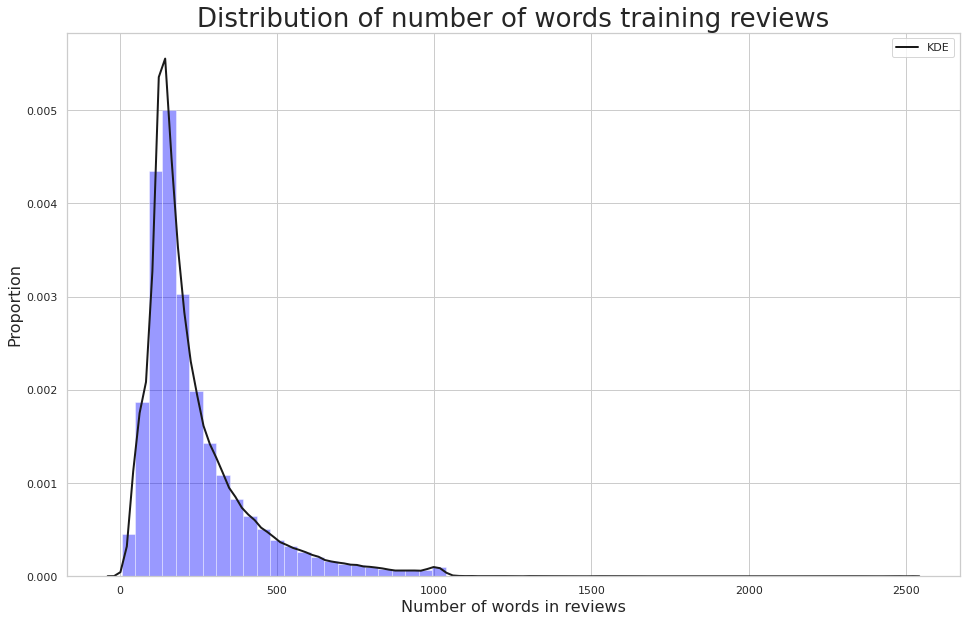

In [21]:
# plotting distribution for number of words in training dataset
train_review_lengths = [len(review.split()) for review in X_train]
dist_graph(train_review_lengths, 16, 10, 'Distribution of number of words training reviews', 'Number of words in reviews', 'Proportion', 'Blue', 58)

# **4. Tokenising & Vectorising with Word2Vec**

For training and testing data

In [22]:
# --------------------------------------------------------------------
# TOKENISING AND VECTORISING IMPORTS

import gensim
import gensim.downloader as api 

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
# --------------------------------------------------------------------
# VECTORISING FUNCTIONS

# looking at the distribution graph above of the number of words in reviews for 
# the training data, the number below seems an appropriate value to
# set of the max number of words in a sequence
MAX_WORDS = 500
EMBEDDING_DIM = 300

# creating tokeniser
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\''
tokenizer = Tokenizer(num_words=MAX_WORDS, filters=filters, lower=True)

In [0]:
# tokenising training and testing features
tokenizer.fit_on_texts(X_train)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [0]:
# defining vocab size and word index
word_idx = tokenizer.word_index
vocab_size = min(len(word_idx) + 1, MAX_WORDS)

In [0]:
# padding training and testing features
X_train_pad = pad_sequences(X_train_tokens, maxlen=MAX_WORDS)
X_test_pad = pad_sequences(X_test_tokens, maxlen=MAX_WORDS)

In [0]:
# turning training and testing labels into array
y_train_np = pd.get_dummies(y_train)
y_test_np = pd.get_dummies(y_test)

In [28]:
# printing the shape of training and testing features and labels
print('Training features shape: ', X_train_pad.shape)
print('Training labels shape  : ', y_train_np.shape)
print('Testing features shape : ', X_test_pad.shape)
print('Testing labels shape   : ', y_test_np.shape)
print('\nWord index size        : ', len(word_idx))

Training features shape:  (40000, 500)
Training labels shape  :  (40000, 2)
Testing features shape :  (10000, 500)
Testing labels shape   :  (10000, 2)

Word index size        :  94449


**Word embedding with pretrined Google Word2Vec model**

In [0]:
# # loading pre-trained word2vec model
# word_vecs = api.load("word2vec-google-news-300", return_path=True)

In [0]:
# word_vecs = KeyedVectors.load_word2vec_format(word_vecs, binary=True)

In [0]:
# # vectorising tokens
# embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
# for word, i in word_idx.items():
#     if i >= MAX_WORDS:
#         continue 
#     try:
#         embedding_vector = word_vecs[word]
#         embedding_matrix[i] = embedding_vector
#     except KeyError:
#         embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)

In [0]:
# pickle_method(file_embedding_matrix, 'wb', embedding_matrix)

In [0]:
embedding_matrix = pickle_method(file_embedding_matrix, 'rb', '')

In [0]:
# del(word_vecs)

# **5. Modelling**

Investigating 2 Models:

2.   LSTM
3.   CNN


In [0]:
# --------------------------------------------------------------------
# MODEL IMPORTS

import multiprocessing

from IPython.display import Image

from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, Embedding, Flatten, GlobalMaxPooling1D
from keras.layers import GRU, LSTM, MaxPooling1D, SpatialDropout1D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [0]:
# Common stata model variables
EPOCHS = 10
BATCH_SIZE = 128

In [0]:
# creating pre-trained embedding layer for LSTM and CNN
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_WORDS, weights=[embedding_matrix], trainable=True)

# enabling callbacks so model stops in case validation loss keeps increasing
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')]

#**5.1 LSTM model**


In [0]:
# # building LSTM model
# m_lstm = Sequential()
# m_lstm.add(embedding_layer)
# m_lstm.add(SpatialDropout1D(0.2))
# m_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# m_lstm.add(Dense(2, activation='sigmoid'))
# m_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# # LSTM model summary
# m_lstm.summary()
# Image(model_to_dot(m_lstm).create(prog='dot', format='png'))

In [0]:
# # fitting on training model and evaluating on validation set
# m_lstm_hist = m_lstm.fit(X_train_pad, y_train_np, validation_split=VAL_SIZE,
#                          epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

In [0]:
# # save lstm model to files
# pickle_method(file_m_lstm_final, 'wb', m_lstm)
# pickle_method(file_m_lstm_hist, 'wb', m_lstm_hist)

In [42]:
# loading back lstm file
m_lstm = pickle_method(file_m_lstm_final, 'rb', '')
m_lstm_hist = pickle_method(file_m_lstm_hist, 'rb', '')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



**LSTM on Test set**

In [0]:
# # predicting LSTM model on testing dataset
# m_lstm_score = m_lstm.evaluate(X_test_pad, y_test_np, verbose=1)
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(m_lstm_score[0], m_lstm_score[1]))

In [0]:
# # save lstm model predicted results to file
# pickle_method(file_m_lstm_result, 'wb', m_lstm_score)

**LSTM plots**

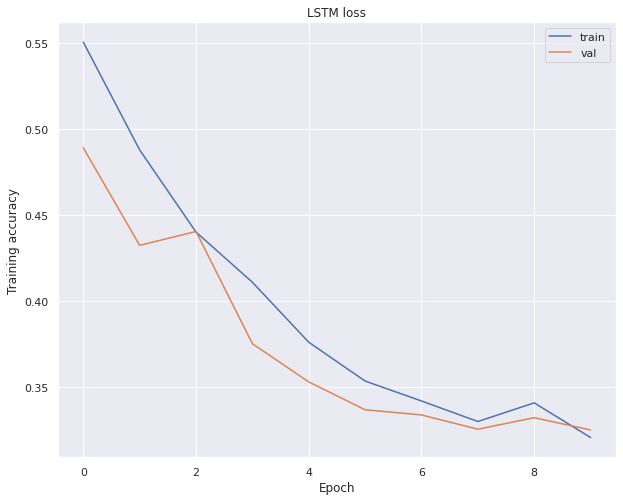

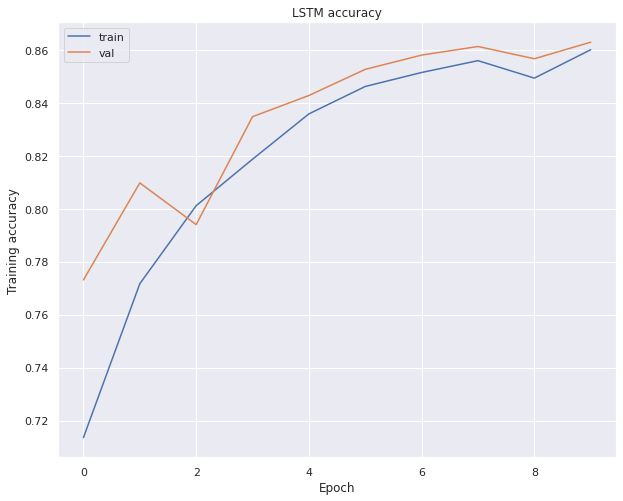

In [45]:
# plotting LSTM model loss and accuracy
plot_model_training(m_lstm_hist, 'LSTM', 'loss', 10, 8)
plot_model_training(m_lstm_hist, 'LSTM', 'acc', 10, 8)

**Predicting LSTM on non-test data**

In [46]:
# LSTM (positive) example test 1
new_pos_review = ['The movie was fun to watch. I enjoyed seeing the main characters develop over the movie. The only thing that could make it better would be a sequel!']
seq = tokenizer.texts_to_sequences(new_pos_review)
padded = pad_sequences(seq, maxlen=MAX_WORDS)
pred = m_lstm.predict(padded)
labels = ['negative', 'positive']
print(pred, labels[np.argmax(pred)])

[[0.37379506 0.6894894 ]] positive


In [47]:
# LSTM (negative) example test 2
new_neg_review = ['I did not enjoy this movie at all. The main actor was dreadful. Waste of time and money.']
seq = tokenizer.texts_to_sequences(new_neg_review)
padded = pad_sequences(seq, maxlen=MAX_WORDS)
pred = m_lstm.predict(padded)
labels = ['negative', 'positive']
print(pred, labels[np.argmax(pred)])

[[0.9100819  0.02578939]] negative


# **5.2 CNN model**

**Using Word2Vec model as vectoriser**

Approach: learn word embeddings first and then pass them to the embedding layer.

Passing a pretrained word embedding layer saves time in training a classification model.


In [0]:
# # defining CNN model
# m_cnn = Sequential()
# m_cnn.add(embedding_layer)
# m_cnn.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
# m_cnn.add(MaxPooling1D(pool_size=2))
# m_cnn.add(Flatten())
# m_cnn.add(Dense(256, activation='relu'))
# m_cnn.add(Dense(1, activation='sigmoid'))
# m_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# # CNN model summary
# m_cnn.summary()
# Image(model_to_dot(m_cnn).create(prog='dot', format='png'))

In [0]:
# # fitting CNN model on training model and evaluating on validation set
# m_cnn_hist = m_cnn.fit(X_train_pad, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
#                        verbose=1, validation_split=VAL_SIZE, callbacks= callbacks)

In [0]:
# # pickle CNN model and model history to files
# pickle_method(file_m_cnn_final, 'wb', m_cnn)
# pickle_method(file_m_cnn_hist, 'wb', m_cnn_hist)

In [52]:
# unpickle CNN model to files
m_cnn = pickle_method(file_m_cnn_final, 'rb', '')
m_cnn_hist = pickle_method(file_m_cnn_hist, 'rb', '')

**Predicting CNN Model on test data**

In [53]:
# predicting CNN model on testing dataset
m_cnn_score = m_cnn.evaluate(X_test_pad, y_test, verbose=1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(m_cnn_score[0], m_cnn_score[1]))

10000/10000 [==============================] - 21s 2ms/step
Test set
  Loss: 0.366
  Accuracy: 0.840


In [0]:
# pickle_method(file_m_cnn_result, 'wb', m_cnn)

**Plotting CNN**

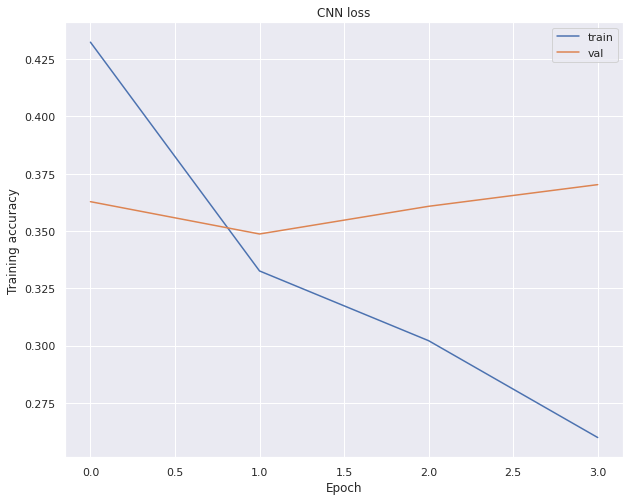

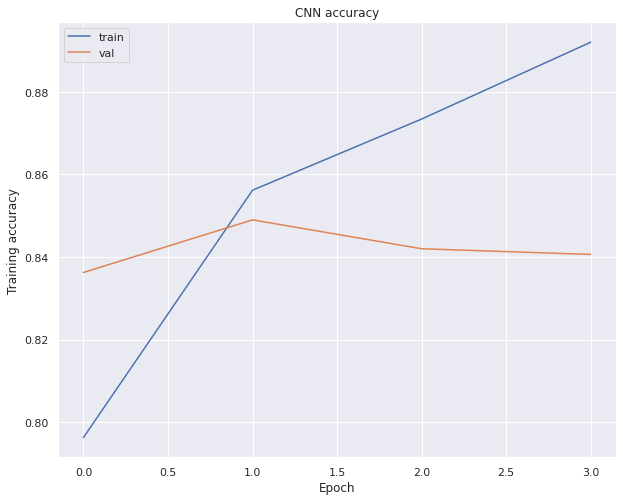

In [55]:
# plotting CNN model loss and accuracy
plot_model_training(m_cnn_hist, 'CNN', 'loss', 10, 8)
plot_model_training(m_cnn_hist, 'CNN', 'acc', 10, 8)

In [56]:
# CNN (positive) example test 1
new_pos_review = ['The movie was fun to watch. I enjoyed seeing the main characters develop over the movie. The only thing that could make it better would be a sequel!']
seq = tokenizer.texts_to_sequences(new_pos_review)
padded = pad_sequences(seq, maxlen=MAX_WORDS)
pred = m_cnn.predict(padded)
labels = ['negative', 'positive']
print(pred, labels[np.argmax(pred)])

[[0.5335994]] negative


In [57]:
# CNN (negative) example test 2
new_neg_review = ['I did not enjoy this movie at all. The main actor was dreadful. Waste of time and money.']
seq = tokenizer.texts_to_sequences(new_neg_review)
padded = pad_sequences(seq, maxlen=MAX_WORDS)
pred = m_cnn.predict(padded)
labels = ['negative', 'positive']
print(pred, labels[np.argmax(pred)])

[[0.01626664]] negative


# **6. Evaluation**

In [0]:
# confusion matrix plot
def confusion_matrix_plt(df_lstm, df_cnn, x_dim, y_dim):
  sns.set(style='whitegrid')
  fig = plt.figure(figsize=(x_dim, y_dim))
  ax1 = plt.subplot(1, 2, 1)
  ax1 = sns.heatmap(df_lstm, cmap= "Blues", annot = True, fmt='')
  ax1.set_title('LSTM confusion matrix', fontsize=22)

  ax2 = plt.subplot(1, 2, 2)
  ax2 = sns.heatmap(df_cnn, cmap= "Blues", annot = True, fmt='')
  ax2.set_title('CNN confusion matrix', fontsize=22)

  plt.show()

In [0]:
# reshaping labels for and defining target names for display
rounded_labels = y_test_np[1]
target_names = ['0','1']

In [0]:
# m_lstm_rounded_preds = m_lstm.predict_classes(X_test_pad, batch_size=128, verbose=0)

# # pickling above as it takes a while to load
# pickle_method(file_m_lstm_pred_classes, 'wb', m_lstm_rounded_preds)

In [0]:
# m_cnn_rounded_preds = m_cnn.predict_classes(X_test_pad, batch_size=128, verbose=0)

# # pickling above as it takes a while to load
# pickle_method(file_m_cnn_pred_classes, 'wb', m_cnn_rounded_preds)

In [0]:
# unpickling lstm and cnn pred classes
m_lstm_rounded_preds = pickle_method(file_m_lstm_pred_classes, 'rb', '')
m_cnn_rounded_preds = pickle_method(file_m_cnn_pred_classes, 'rb', '')

**6.1 LSTM Model Confusion Matrix**


In [63]:
# LSTM classification report
m_lstm_cv_report = classification_report(rounded_labels, m_lstm_rounded_preds, target_names = ['0','1'])
print('LSTM Classification Report: ')
print(m_lstm_cv_report)

LSTM Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      5000
           1       0.87      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [64]:
# confusion Matrix for LSTM
m_lstm_cm = confusion_matrix(rounded_labels, m_lstm_rounded_preds)
df_lstm_cm = pd.DataFrame(m_lstm_cm, index=[0,1], columns=[0,1])
df_lstm_cm.index.name = 'Actual'
df_lstm_cm.columns.name = 'Predicted'
m_lstm_cm

array([[4344,  656],
       [ 770, 4230]])

**6.2 CNN Model Evaluation**

In [65]:
# CNN classification report
m_cnn_cv_report = classification_report(rounded_labels, m_cnn_rounded_preds, target_names=target_names)
print('CNN Classification Report: ')
print(m_cnn_cv_report)

CNN Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      5000
           1       0.83      0.85      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [66]:
# confusion Matrix for CNN
m_cnn_cm = confusion_matrix(rounded_labels, m_cnn_rounded_preds)
df_cnn_cm = pd.DataFrame(m_cnn_cm, index=[0,1], columns=[0,1])
df_cnn_cm.index.name = 'Actual'
df_cnn_cm.columns.name = 'Predicted'
m_cnn_cm

array([[4138,  862],
       [ 734, 4266]])

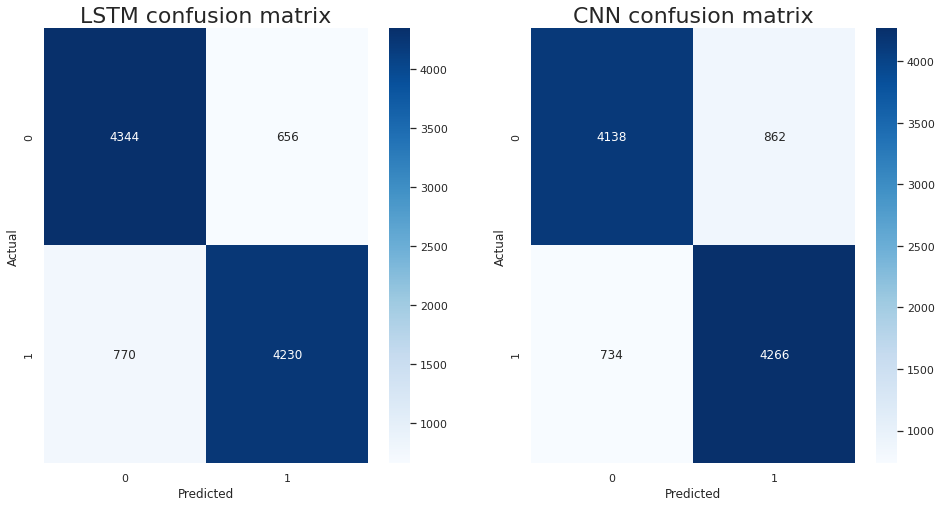

In [67]:
# plot of LSTM confusion matrix
confusion_matrix_plt(df_lstm_cm, df_cnn_cm, 16, 8)



---


**END**